In [17]:
from data.dataset import MFData
from run_lib import run_hogp_2d
from infras.misc import cprint, create_path, get_logger
import os
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from tqdm.auto import tqdm, trange
import tensorly as tl
import torch.nn.functional as F

class MLP(nn.Module):
    """
    Simple fully connected neural network

    Args:
        in_dim
        hidden_dim:
        hidden_layers:
        out_dim:
        act:
    """

    def __init__(
            self,
            in_dim: int,
            hidden_dim: int,
            hidden_layers: int,
            out_dim: int,
            act: str,
    ):
        super().__init__()

        layer_configs = [in_dim] + [hidden_dim] * hidden_layers + [out_dim]

        if act == 'tanh':
            act_fn = nn.Tanh()
        elif act == 'relu':
            act_fn = nn.ReLU()
        elif act == 'elu':
            act_fn = nn.ELU()
        #

        layers = []
        for i in range(len(layer_configs) - 2):
            layers.append(nn.Linear(layer_configs[i], layer_configs[i + 1]))
            nn.init.xavier_normal_(layers[-1].weight)
            nn.init.zeros_(layers[-1].bias)
            layers.append(act_fn)
        #

        layers.append(nn.Linear(layer_configs[-2], layer_configs[-1]))
        nn.init.xavier_normal_(layers[-1].weight)
        nn.init.zeros_(layers[-1].bias)

        self.net = nn.Sequential(*layers)

    def forward(
            self,
            x: torch.Tensor,
    ) -> torch.Tensor:
        return self.net(x)



class ABLR_v2(nn.Module):
    """
    Adaptive Bayesian Linear Regressor

    Args:
        in_dim
        hidden_dim:
        hidden_layers:
        base_dim:
        out_dim:
        act:
    """

    def __init__(
            self,
            in_dim: int,
            hidden_dim: int,
            hidden_layers: int,
            base_dim: int,
            out_dim: int,
            act: str,
    ):
        super().__init__()

        self.base_net = MLP(in_dim, hidden_dim, hidden_layers, base_dim, act)

        self.Wmu = nn.Parameter(torch.zeros(size=[out_dim, base_dim]))
        self.bmu = nn.Parameter(torch.zeros(size=[out_dim, ]))

        nn.init.xavier_normal_(self.Wmu)
        nn.init.zeros_(self.bmu)

        self.Wrho = nn.Parameter(torch.ones(size=[out_dim, base_dim]))
        self.brho = nn.Parameter(torch.ones(size=[out_dim, ]))

        #         self.log_tau = nn.Parameter(torch.tensor(0.0))

        nn.init.uniform_(self.Wrho, -5, -4)
        nn.init.uniform_(self.brho, -5, -4)

        self.register_buffer('dummy', torch.tensor([]))

        self.normal = torch.distributions.Normal(0.0, 1.0)

    def sample_posts(self, ns):
        samples = []
        logprob_priors = []
        logprob_posts = []

        for i in range(ns):
            Wstd = torch.log1p(torch.exp(self.Wrho))
            bstd = torch.log1p(torch.exp(self.brho))

            Ws = self.Wmu + self.normal.sample(Wstd.shape).to(self.dummy) * Wstd
            bs = self.bmu + self.normal.sample(bstd.shape).to(self.dummy) * bstd

            samples.append((Ws, bs))

            log_prior_Ws = self.normal.log_prob(Ws)
            log_prior_bs = self.normal.log_prob(Ws)

            log_posterior_Ws = -torch.log(Wstd) - np.log(np.sqrt(2 * np.pi)) - \
                               0.5 * (torch.square((Ws - self.Wmu) / Wstd))
            log_posterior_bs = -torch.log(bstd) - np.log(np.sqrt(2 * np.pi)) - \
                               0.5 * (torch.square((bs - self.bmu) / bstd))

            log_prior = log_prior_Ws.sum() + log_prior_bs.sum()
            log_posterior = log_posterior_Ws.sum() + log_posterior_bs.sum()

            logprob_priors.append(log_prior)
            logprob_posts.append(log_posterior)

        #

        return samples, logprob_priors, logprob_posts

    def forward(self, x):
        h = self.base_net(x)
        return F.linear(h, self.Wmu, self.bmu)

    def forward_by_sample(self, x, Ws, bs):
        h = self.base_net(x)
        return F.linear(h, Ws, bs)



class FidNet(nn.Module):

    def __init__(
            self,
            in_dim,
            rank,
            meshes,
            hidden_dim,
            hidden_layers,
            activation
    ):
        super().__init__()

        assert len(meshes) == 2  # restrict 2D spatial-temporal

        self.in_dim = in_dim
        self.h_dim = rank
        self.out_dim = meshes[0] * meshes[1]
        self.meshes = meshes

        self.hidden_model = ABLR_v2(
            in_dim=in_dim,
            hidden_dim=hidden_dim,
            hidden_layers=hidden_layers - 1,
            base_dim=hidden_dim,
            out_dim=rank,
            act=activation,
        )

        #         for name, param in self.hidden_model.named_parameters():
        #             if param.requires_grad:
        #                 print (name, param.data.shape)

        self.Aw = nn.Parameter(torch.ones(size=[self.out_dim, rank]))
        self.Ab = nn.Parameter(torch.ones(size=[self.out_dim, ]))

        #         print(self.Aw.shape)
        #         print(self.Ab.shape)

        nn.init.xavier_normal_(self.Aw)
        nn.init.zeros_(self.Ab)

        self.register_buffer('dummy', torch.tensor([]))
        self.normal = torch.distributions.Normal(0.0, 1.0)

    def forward(self, x):
        h = self.hidden_model(x)
        # print(h.shape)
        y = F.linear(h, self.Aw, self.Ab)
        # print(y.shape)
        return y

    def forward_hidden(self, x):
        h = self.hidden_model(x)
        # print(h.shape)
        return h

    def sample_posts(self, ns=10):
        samples, lpriors, lposts = self.hidden_model.sample_posts(ns)
        # print(samples[0][0].shape)
        # print(samples[1][0].shape)
        # print(lpriors)
        # print(lposts)
        return samples, lpriors, lposts

    def forward_by_samples(self, x, samples):
        ns = len(samples)

        Ysamples = []

        for i in range(ns):
            Ws = samples[i][0]
            bs = samples[i][1]

            hs = self.hidden_model.forward_by_sample(x, Ws, bs)
            ys = F.linear(hs, self.Aw, self.Ab)

            Ysamples.append(ys.unsqueeze(0))
        #

        Ysamples = torch.cat(Ysamples)

        return Ysamples

    #     def forward_hidden_by_samples(self, x, samples):

    #         ns = len(samples)

    #         Hsamples = []

    #         for i in range(ns):

    #             Ws = samples[i][0]
    #             bs = samples[i][1]

    #             hs = self.hidden_model.forward_by_sample(x, Ws, bs)
    #             Hsamples.append(hs.unsqueeze(0))
    #         #

    #         Hsamples = torch.cat(Hsamples)

    #         return Hsamples

    def forward_hidden_one_sample(self, x, Ws, bs):
        hs = self.hidden_model.forward_by_sample(x, Ws, bs)

        return hs


class DMF2d(nn.Module):

    def __init__(
            self,
            config,
            nfids,
            fids_list,
            in_dim,
            rank,
            meshes,
            hidden_dim,
            hidden_layers,
            activation
    ):

        super().__init__()

        self.config = config

        self.nfids = nfids
        self.fids_list = fids_list

        assert self.nfids == len(self.fids_list)

        self.in_dim = in_dim
        self.out_dim = meshes[0] * meshes[1]

        self.rank = rank
        self.meshes = meshes
        self.hidden_dim = hidden_dim
        self.hidden_layers = hidden_layers
        self.activation = activation

        self.mf_hidden_models = nn.ModuleList(self._init_hidden_models(nfids))

        self.log_tau = nn.Parameter(torch.tensor(0.0))

        self.register_buffer('dummy', torch.tensor([]))

    def _init_hidden_models(self, nfids):

        mf_hidden_models = []
        for i in range(nfids):
            if i == 0:
                fidh = FidNet(
                    self.in_dim,
                    self.rank,
                    self.meshes,
                    self.hidden_dim,
                    self.hidden_layers,
                    self.activation
                )
                mf_hidden_models.append(fidh)
            else:
                fidh = FidNet(
                    self.in_dim + self.rank,
                    self.rank,
                    self.meshes,
                    self.hidden_dim,
                    self.hidden_layers,
                    self.activation
                )
                mf_hidden_models.append(fidh)
            #
        #

        return mf_hidden_models

    def forward(self, fidx, x):

        hidden_outputs = []

        for i in range(fidx + 1):
            if i == 0:
                hi = self.mf_hidden_models[i].forward_hidden(x)
                hidden_outputs.append(hi)
            else:
                hi_1 = hidden_outputs[-1]
                aug_inputs = torch.hstack([hi_1, x])
                hi = self.mf_hidden_models[i].forward_hidden(aug_inputs)
                hidden_outputs.append(hi)
            #
        #

        hfid = hidden_outputs[-1]

        Aw_fid = self.mf_hidden_models[fidx].Aw
        Ab_fid = self.mf_hidden_models[fidx].Ab

        yfid = F.linear(hfid, Aw_fid, Ab_fid)

        return yfid

    def sample_fids_posts(self, ns):

        fids_posts_list = []
        fids_lpriors_list = []
        fids_lposts_list = []

        for i in range(self.nfids):
            fid_samples, fid_lpriors, fid_lposts = self.mf_hidden_models[i].sample_posts(ns)

            fids_posts_list.append(fid_samples)
            fids_lpriors_list.append(fid_lpriors)
            fids_lposts_list.append(fid_lposts)
        #

        return fids_posts_list, fids_lpriors_list, fids_lposts_list

    def forward_by_samples(self, fidx, x, samples_list):

        Aw_fid = self.mf_hidden_models[fidx].Aw
        Ab_fid = self.mf_hidden_models[fidx].Ab

        ns = len(samples_list[0])

        Ys = []

        for j in range(ns):

            hidden_outputs = []

            for i in range(fidx + 1):
                fid_post_samples = samples_list[i][j]
                Ws = fid_post_samples[0]
                bs = fid_post_samples[1]
                # print(Ws.shape)
                # print(bs.shape)

                if i == 0:
                    hi = self.mf_hidden_models[i].forward_hidden_one_sample(x, Ws, bs)
                    hidden_outputs.append(hi)
                else:
                    hi_1 = hidden_outputs[-1]
                    aug_inputs = torch.hstack([hi_1, x])
                    hi = self.mf_hidden_models[i].forward_hidden_one_sample(aug_inputs, Ws, bs)
                    hidden_outputs.append(hi)
                #
            #

            hfid = hidden_outputs[-1]

            yfid = F.linear(hfid, Aw_fid, Ab_fid)

            Ys.append(yfid.unsqueeze(0))
        #

        Ys = torch.cat(Ys)

        return Ys

    def _eval_fid_llh(self, X, y, fidx, samples_list):

        fid = self.fids_list[fidx]

        #         print(self.nfids)
        #         print(self.fids_list)
        #         print(fid)

        assert X.shape[0] == y.shape[0]
        #         print(X.shape)
        #         print(y.shape)

        dimy = fid ** 2
        N = X.shape[0]

        ns = len(samples_list[0])

        #         cprint('b', ns)
        #         cprint('b', N)

        Ft_samples = self.forward_by_samples(fidx, X, samples_list)
        #         cprint('r', Ft_samples.shape)
        pred_2d_samples = Ft_samples.reshape([-1] + self.meshes)
        #         cprint('r', pred_2d_samples.shape)

        interp_pred_2d_samples = torch.nn.functional.interpolate(
            pred_2d_samples.unsqueeze(1),
            size=fid,
            mode=self.config.data.interp,
        ).squeeze(1)

        #         cprint('r', interp_pred_2d_samples.shape)

        interp_pred_2d_samples = interp_pred_2d_samples.reshape([ns, N] + [fid, fid])

        #         cprint('r', interp_pred_2d_samples.shape)

        interp_pred_flat_samples = interp_pred_2d_samples.reshape([ns, N] + [-1])

        #         cprint('r', interp_pred_flat_samples.shape)
        #         cprint('r', y.shape)

        llh_scaler_terms = -0.5 * dimy * N * np.log(2 * np.pi) + 0.5 * N * dimy * self.log_tau
        # print(interp_pred_flat_samples.shape)

        ######################################
        #   WARNING: @Broadcasting Involved  #
        ######################################
        # - interp_pred_flat_samples:  T by N by d1*d2
        # - y: N by d1*d2
        llh_quad_terms = \
            torch.sum(torch.square(interp_pred_flat_samples - y), dim=(1, 2)).reshape([-1, 1])

        llh_samples = llh_scaler_terms - 0.5 * torch.exp(self.log_tau) * llh_quad_terms
        # print((llh_samples-llh_buff).square().sum())

        # print(llh_samples.shape)
        # print(log_priors.shape)
        # print(log_posts.shape)

        # elbo_samples = llh_samples - log_posts + log_priors
        # print(elbo_samples)

        return llh_samples

    def eval_nelbo(self, X_list, y_list, ns=10):

        fids_posts_list, fids_lpriors_list, fids_lposts_list = self.sample_fids_posts(ns)

        log_prior_samples = []
        log_post_samples = []

        for i in range(self.nfids):
            fid_lpriors = torch.vstack(fids_lpriors_list[i])
            fid_lposts = torch.vstack(fids_lposts_list[i])
            log_prior_samples.append(fid_lpriors)
            log_post_samples.append(fid_lposts)
        #

        log_prior_samples = torch.hstack(log_prior_samples)
        log_post_samples = torch.hstack(log_post_samples)

        log_prior_samples = log_prior_samples.sum(1).reshape([-1, 1])
        log_post_samples = log_post_samples.sum(1).reshape([-1, 1])

        fids_llh_samples = []

        for fidx in range(self.nfids):
            fid = self.fids_list[fidx]

            Xm = X_list[fid]
            ym = y_list[fid]

            #             cprint('b', Xm.shape)
            #             cprint('b', ym.shape)

            llh_m = self._eval_fid_llh(Xm, ym, fidx, fids_posts_list)
            fids_llh_samples.append(llh_m)
        #             print(llh_m.shape)
        #

        fids_llh_samples = torch.hstack(fids_llh_samples)
        fids_llh = torch.sum(fids_llh_samples, dim=1, keepdim=True)
        #         print(fids_llh.shape)
        #         print(log_prior_samples.shape)
        #         print(log_post_samples.shape)

        elbo_samples = fids_llh - log_post_samples + log_prior_samples
        #         elbo_samples = fids_llh
        nelbo = -elbo_samples.sum()

        #         print(fids_elbos)
        # #         nelbo = sum(fids_elbos)

        # print(nelbo)

        return nelbo

    def _eval_fid_rmse(self, X, y, fidx):

        with torch.no_grad():
            fid = self.fids_list[fidx]

            assert X.shape[0] == y.shape[0]
            N = X.shape[0]
            d = fid ** 2
            pred = self.forward(fidx, X)
            # print(pred.shape)
            pred_2d = pred.reshape([N] + self.meshes)
            # print(pred_2d.shape)
            interp_pred_2d = torch.nn.functional.interpolate(
                pred_2d.unsqueeze(1),
                size=fid,
                mode='bilinear',
            ).squeeze(1)
            # print(interp_pred_2d.shape)

            interp_pred = interp_pred_2d.reshape([N, -1])
            # print(interp_pred.shape)

            rmse = torch.sqrt(torch.mean(torch.square(interp_pred - y))) / \
                   torch.sqrt(torch.square(y).mean())

            return rmse

    def eval_rmse(self, X_list, y_list):

        fids_rmse = []

        for fidx in range(self.nfids):
            fid = self.fids_list[fidx]

            Xm = X_list[fid]
            ym = y_list[fid]

            rmse_m = self._eval_fid_rmse(Xm, ym, fidx)
            #             print(rmse_m)
            fids_rmse.append(rmse_m)
        #

        return fids_rmse

    def _batch_outputs_entropy_flat_mm(self, Fs_flat):

        Fs = Fs_flat

        if Fs.ndim == 2:
            Fs = Fs.unsqueeze(0)
        assert Fs.ndim == 3

        T = Fs.shape[0]
        N = Fs.shape[1]
        d = Fs.shape[2]

        # print(ns, N, dim)

        Fs = Fs.permute((1, 0, 2))  # N by T by d1*d2
        # print(Fs.shape)
        Fmu = Fs.mean(1).unsqueeze(1)
        # print(Fmu.shape)

        S = (Fs - Fmu) / (np.sqrt(T - 1))
        # print(S.shape)
        ST = S.permute((0, 2, 1))
        # print(ST.shape)

        I = torch.eye(T).to(self.dummy.device)
        bI = I.repeat([N, 1, 1])
        # print(bI.shape)
        bSST = torch.bmm(S, ST)
        # print(bSST.shape)

        blogdet = torch.logdet(bSST + (1 / torch.exp(self.log_tau)) * bI).reshape([-1, 1])
        bH = 0.5 * (blogdet - (d - T) * self.log_tau)

        return bH

    #     def eval_outputs_entropy_mm(self, X, t, samples):

    #         Ft_samples = self.forward_by_samples(t, X, samples)
    #         #H = self._batch_outputs_entropy_mm(Ft_samples)
    #         H = self._batch_outputs_entropy_flat_mm(Ft_samples.flatten(-2,-1))

    # #         Hs = self._single_outputs_entropy_mm(Ft_samples)
    # #         err = torch.sum(torch.square(H-Hs))
    # #         #cprint('r', err)

    #         return H

    def eval_dmfal_mutual_info_mm(self, fidx, x, samples_list):

        if x.ndim == 0 or x.ndim == 1:
            x = x.reshape([1, -1])

        assert x.shape[0] == 1

        Fx_m = self.forward_by_samples(fidx, x, samples_list)
        Fx_M = self.forward_by_samples(self.nfids - 1, x, samples_list)
        Fx_mM = torch.cat([Fx_m, Fx_M], dim=-1)
        # print(Fx_mM.shape)

        Hm = self._batch_outputs_entropy_flat_mm(Fx_m)
        HM = self._batch_outputs_entropy_flat_mm(Fx_M)
        HmM = self._batch_outputs_entropy_flat_mm(Fx_mM)

        ImM = (Hm + HM - HmM).mean()

        # print(ImM)

        return ImM





def run_dmf_2d(
        config,
        dataset,
):

    # Xtr_list, ytr_list, t_list_tr = dataset.get_data(train=True, device=config.device)
    # Xte_list, yte_list, t_list_te = dataset.get_data(train=False, device=config.device)

    Xtr_list, ytr_list, ttr_list = dataset.get_data(
        train=True,
        scale=config.data.normalize,
        device=config.device,
    )

    Xte_list, yte_list, tte_list = dataset.get_data(
        train=False,
        scale=config.data.normalize,
        device=config.device,
    )

    model = DMF2d(
        config,
        nfids=len(list(Xte_list.keys())),
        fids_list=list(Xte_list.keys()),
        in_dim=dataset.input_dim,
        rank=config.model.rank,
        meshes=[config.data.fid_max, config.data.fid_max],
        hidden_dim=config.model.hidden_dim,
        hidden_layers=config.model.hidden_layers,
        activation=config.model.activation,
    ).to(config.device)

    # for name, param in model.named_parameters():
    #     if param.requires_grad:
    #         print (name, param.data.shape)



    optimizer = Adam(model.parameters(), lr=config.optim.learning_rate, weight_decay=config.optim.weight_decay)

    if config.optim.scheduler == 'CosAnnealingLR':
        cprint('y', 'INFO: Cosine annealing scheduler applied.')
        iterations = config.training.epochs
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=iterations)
    elif config.optim.scheduler == 'ReduceLROnPlateau':
        cprint('y', 'INFO: Reduce on plateau scheduler applied.')
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', min_lr=config.optim.minimum_learning_rate)
    elif config.optim.scheduler == 'NA':
        scheduler = None
        cprint('y', 'INFO: no scheduler applied.')
        cprint('y', 'training with no scheduler used...')

    hist_nrmse_tr = []
    hist_nrmse_te = []

    best_rmse = np.inf

    for ie in tqdm(range(config.training.epochs+1)):

        optimizer.zero_grad()

        loss = model.eval_nelbo(Xtr_list, ytr_list, ns=config.training.ns)
        loss.backward()
        optimizer.step()

        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            rmse_list_te = model.eval_rmse(Xte_list, yte_list)
            scheduler.step(rmse_list_te[config.data.fid_list_te[-1]])
        elif isinstance(scheduler, torch.optim.lr_scheduler.CosineAnnealingLR):
            scheduler.step()

        if ie % config.testing.freq == 0:

            with torch.no_grad():

                fids_rmse_tr = model.eval_rmse(Xtr_list, ytr_list)
                fids_rmse_te = model.eval_rmse(Xte_list, yte_list)
                fids_list = list(Xtr_list.keys())

                # cprint('r', fids_rmse_tr)
                # cprint('r', fids_rmse_te)

                nrmse_tr = fids_rmse_tr[-1].item()
                nrmse_te = fids_rmse_te[-1].item()

                if nrmse_te < best_rmse:
                    best_rmse = nrmse_te
#                     torch.save(model.state_dict(), os.path.join(exp_dicts_workdir, 'model.pt'))


                info_str = '\nepoch={}, nelbo={:.5f}, best_rmse={:.5f}\n'.format(ie, loss.item(), best_rmse)
                info_str += '  - nrmse_tr={}\n'.format(nrmse_tr)
                info_str += '  - nrmse_te={}\n'.format(nrmse_te)
#                 logger.info(info_str)

                hist_nrmse_tr.append(nrmse_tr)
                hist_nrmse_te.append(nrmse_te)
            #
        #
    #

    hist_nrmse_tr = np.array(hist_nrmse_tr)
    hist_nrmse_te = np.array(hist_nrmse_te)

    return hist_nrmse_tr, hist_nrmse_te

class DataFilesConfig:
    def __init__(self, path, fid_list_te, fid_list_tr, generate, interp, n_threas, ns_list_te, ns_list_tr):
        self.path = path
        self.fid_list_te = fid_list_te
        self.fid_list_tr = fid_list_tr
        self.generate = generate
        self.interp = interp
        self.n_threas = n_threas
        self.ns_list_te = ns_list_te
        self.ns_list_tr = ns_list_tr

class ModelConfig:
    def __init__(self, method, rank):
        self.method = method
        self.rank = rank
        self.hidden_dim = 40
        self.hidden_layers = 2
        self.activation = 'tanh'

class TrainingConfig:
    def __init__(self, epochs):
        self.epochs = epochs
        self.ns = 10

class DataConfig:
    def __init__(self, domain, fold, normalize, target_fidelity):
        self.domain = domain
        self.fold = fold
        self.normalize = normalize
        self.target_fidelity = target_fidelity
        self.fid_max = 64
        self.interp = 'bilinear'

class Optim:
    def __init__(self):
        self.learning_rate = 0.001
        self.weight_decay = 1e-05
        self.scheduler = 'CosAnnealingLR'

class Testing:
    def __init__(self):
        self.freq = 5
        
class Config:
    def __init__(self, model, training, data, datafiles, optim, testing):
        self.model = model
        self.training = training
        self.data = data
        self.datafiles = datafiles
        self.device = 'cpu'
        self.optim = optim
        self.testing = testing

optim_config = Optim()
testing_config = Testing()
model_config = ModelConfig(method='dmf', rank=5)
training_config = TrainingConfig(epochs=5000)
data_config = DataConfig(domain='heat', fold=1, normalize=True, target_fidelity=64)
datafiles_config = DataFilesConfig(
    path='pde_data',
    fid_list_te=[8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 128, 136, 144, 152, 160],
    fid_list_tr=[8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 128, 136, 144, 152, 160],
    generate=False,
    interp='linear',
    n_threas=4,
    ns_list_te=[512]*20,
    ns_list_tr=[512]*20
)

config = Config(model=model_config, training=training_config, data=data_config, datafiles=datafiles_config, optim=optim_config, testing=testing_config)
# workdir = os.path.join(
#         workdir,
#         config.model.name,
#         'rank{}'.format(config.model.rank),
#         'fold{}'.format(config.data.fold)
#     )
# exp_log_workdir = os.path.join(workdir, 'logs')

# logger = get_logger(os.path.join(exp_log_workdir, 'logging.txt'), displaying=False)

dataset = MFData(
    config,
    domain='Heat',
    fid_min=8,
    fid_max=64,
    t_min=0.0,
    t_max=1.0,
    target_fidelity=64,
    fid_list_tr=[8, 16, 32, 64],
    fid_list_te=[8, 16, 32, 64],
    ns_list_tr=[100, 50, 50, 20],
    ns_list_te=[256, 256, 256, 256],
)
hist_nrmse_tr, hist_nrmse_te = run_dmf_2d(config, dataset)
print(hist_nrmse_te)

Loading saved data threads...
(Train) fid=8, Part1/4 found at pde_data/Heat/train/fidelity_8/part0
(Train) fid=8, Part2/4 found at pde_data/Heat/train/fidelity_8/part1
(Train) fid=8, Part3/4 found at pde_data/Heat/train/fidelity_8/part2
(Train) fid=8, Part4/4 found at pde_data/Heat/train/fidelity_8/part3
(Train) fid=16, Part1/4 found at pde_data/Heat/train/fidelity_16/part0
(Train) fid=16, Part2/4 found at pde_data/Heat/train/fidelity_16/part1
(Train) fid=16, Part3/4 found at pde_data/Heat/train/fidelity_16/part2
(Train) fid=16, Part4/4 found at pde_data/Heat/train/fidelity_16/part3
(Train) fid=24, Part1/4 found at pde_data/Heat/train/fidelity_24/part0
(Train) fid=24, Part2/4 found at pde_data/Heat/train/fidelity_24/part1
(Train) fid=24, Part3/4 found at pde_data/Heat/train/fidelity_24/part2
(Train) fid=24, Part4/4 found at pde_data/Heat/train/fidelity_24/part3
(Train) fid=32, Part1/4 found at pde_data/Heat/train/fidelity_32/part0
(Train) fid=32, Part2/4 found at pde_data/Heat/train/fi

(Test) fid=48, Part3/4 found at pde_data/Heat/test/fidelity_48/part2
(Test) fid=48, Part4/4 found at pde_data/Heat/test/fidelity_48/part3
(Test) fid=56, Part1/4 found at pde_data/Heat/test/fidelity_56/part0
(Test) fid=56, Part2/4 found at pde_data/Heat/test/fidelity_56/part1
(Test) fid=56, Part3/4 found at pde_data/Heat/test/fidelity_56/part2
(Test) fid=56, Part4/4 found at pde_data/Heat/test/fidelity_56/part3
(Test) fid=64, Part1/4 found at pde_data/Heat/test/fidelity_64/part0
(Test) fid=64, Part2/4 found at pde_data/Heat/test/fidelity_64/part1
(Test) fid=64, Part3/4 found at pde_data/Heat/test/fidelity_64/part2
(Test) fid=64, Part4/4 found at pde_data/Heat/test/fidelity_64/part3
(Test) fid=72, Part1/4 found at pde_data/Heat/test/fidelity_72/part0
(Test) fid=72, Part2/4 found at pde_data/Heat/test/fidelity_72/part1
(Test) fid=72, Part3/4 found at pde_data/Heat/test/fidelity_72/part2
(Test) fid=72, Part4/4 found at pde_data/Heat/test/fidelity_72/part3
(Test) fid=80, Part1/4 found at pd

  0%|          | 0/5001 [00:00<?, ?it/s]

[0.99978542 0.99385058 0.977333   ... 0.20990154 0.20990157 0.20990158]


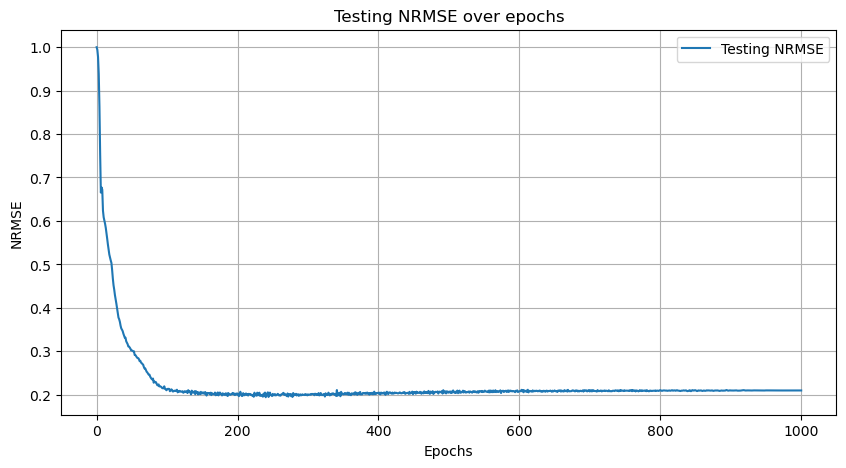

In [18]:
import matplotlib.pyplot as plt

# Assuming hist_nrmse_te is a one-dimensional numpy array containing the testing NRMSE
plt.figure(figsize=(10, 5))
plt.plot(hist_nrmse_te, label='Testing NRMSE')
plt.xlabel('Epochs')
plt.ylabel('NRMSE')
plt.legend()
plt.grid(True)
plt.title('Testing NRMSE over epochs')
plt.show()